Checking required packages...
Please select the data folder window...
Selected Directory: D:/python_workplace/ESP32_autonomous_driving/training_data
Original data count: 2161
Filtered data count (removed backward): 2160
Loading images and syncing labels...


100%|█████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:05<00:00, 400.85it/s]


Final loaded tensors shape: (2160, 120, 160, 3)
Final loaded targets shape: (2160,)


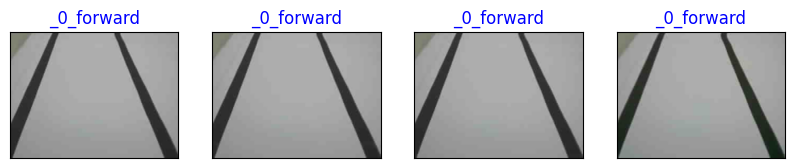

Train shapes: (1728, 120, 160, 3), (1728, 4)
Test shapes: (216, 120, 160, 3), (216, 4)
Valid shapes: (216, 120, 160, 3), (216, 4)
Building EfficientNetB0 Model...
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 120, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 128)               163968    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                            

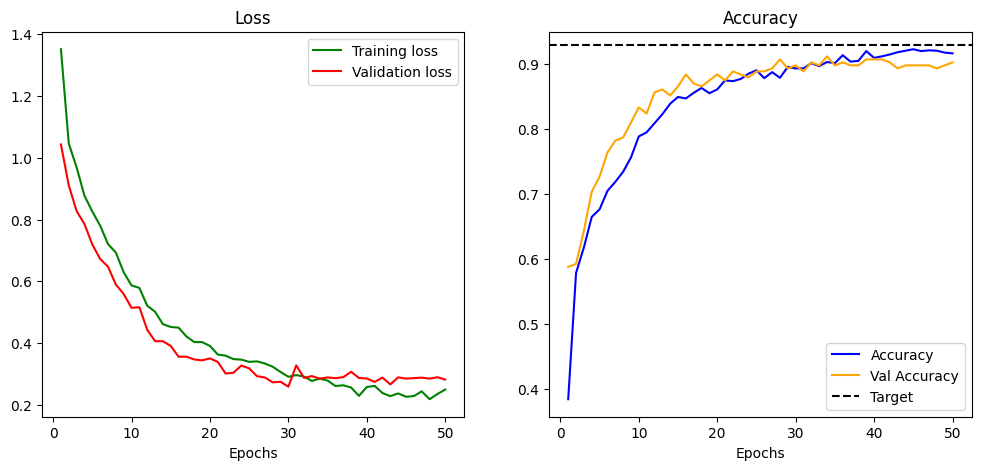

Saving weights to weights_EN_20251226113009.h5...
Success! Weights saved to weights_EN_20251226113009.h5
Evaluating model...
Loading weights from: weights_EN_20251226113009.h5
Model loaded successfully.
7/7 [==============================] - 1s 40ms/step


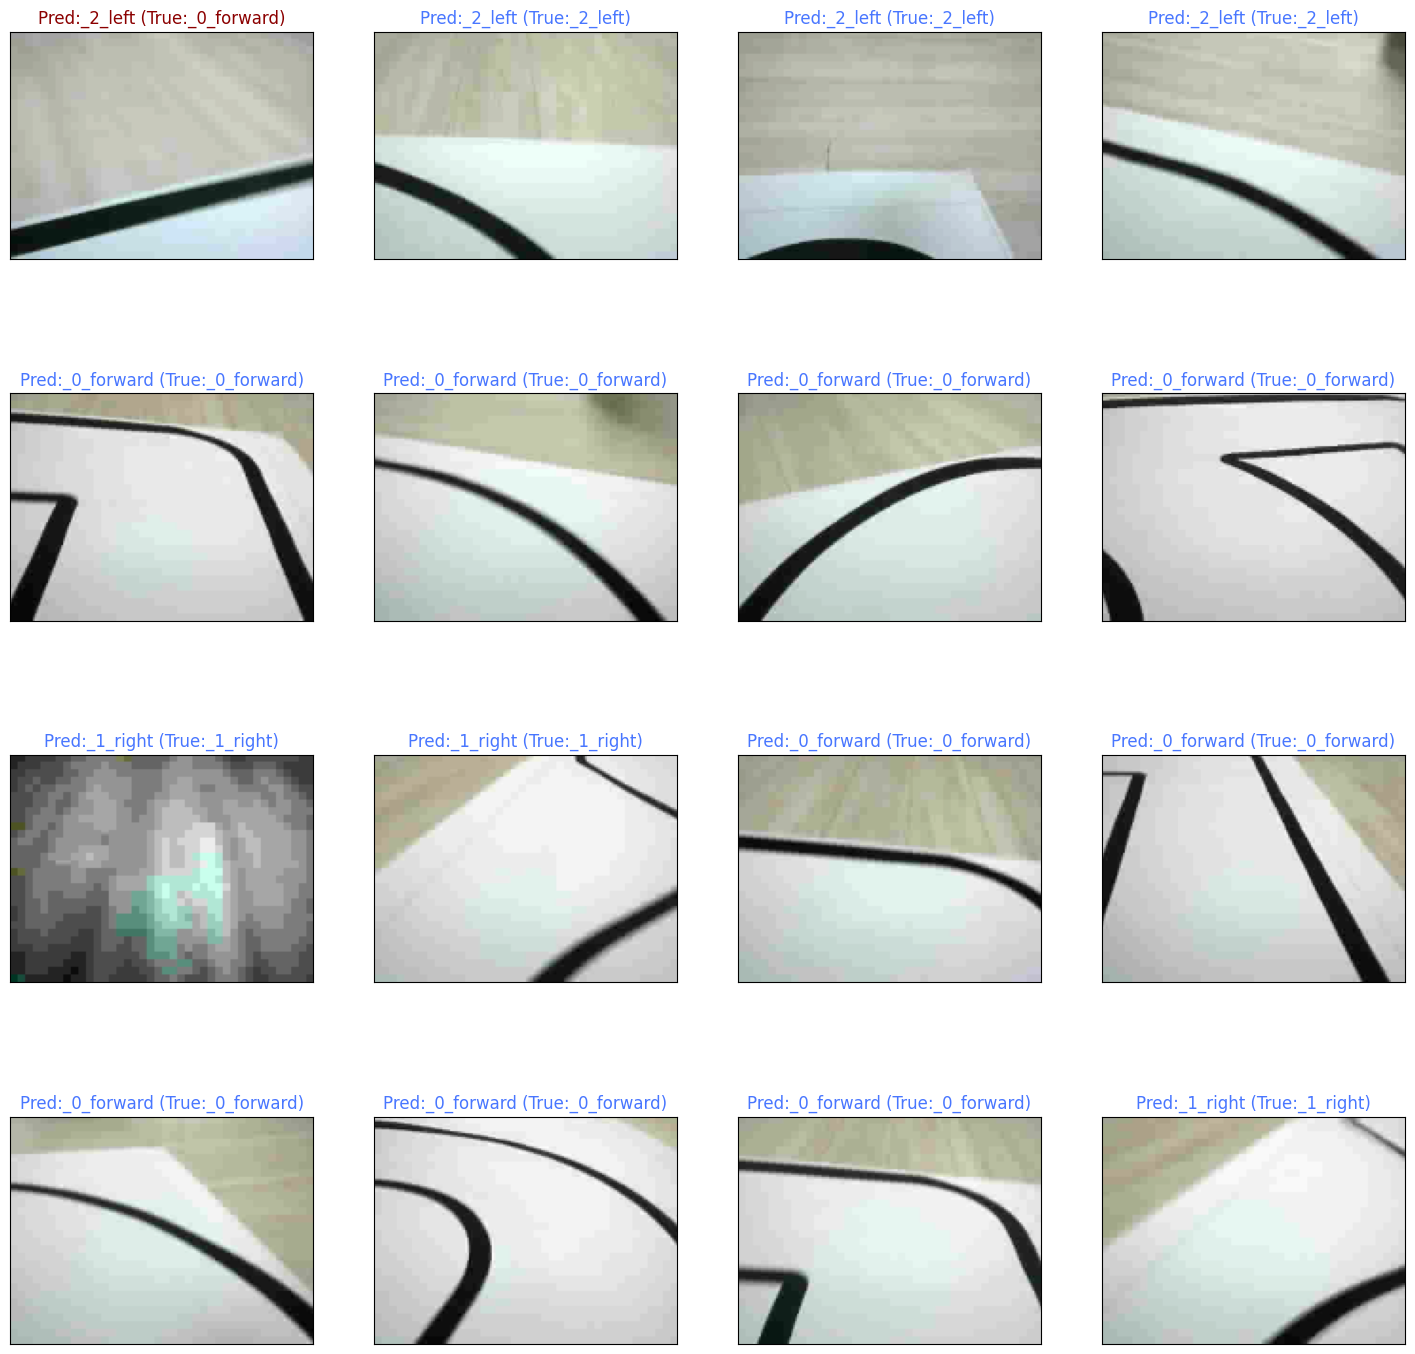

In [13]:
import sys
import subprocess
import importlib
import os
import tkinter as tk
from tkinter import filedialog
from datetime import datetime
import math

# ---------------------------------------------------------
# 1. 패키지 자동 설치 함수
# ---------------------------------------------------------
def install_package(module_name, package_name=None):
    if package_name is None:
        package_name = module_name
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {package_name} ...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installation completed")
        except subprocess.CalledProcessError as e:
            print(f"{package_name} installation failed (exit code {e.returncode})")
            sys.exit(1)
        
# 필수 패키지 확인 및 설치
print("Checking required packages...")
install_package("tensorflow", "tensorflow==2.10.0")
install_package("numpy")
install_package("pandas")
install_package("tqdm")
install_package("PIL", "Pillow")
install_package("cv2", "opencv-python")
install_package("matplotlib")
install_package("sklearn", "scikit-learn")

# ---------------------------------------------------------
# 2. 라이브러리 임포트
# ---------------------------------------------------------
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from tqdm import tqdm
from PIL import ImageFile
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ---------------------------------------------------------
# 3. 데이터 로드 및 전처리
# ---------------------------------------------------------

print("Please select the data folder window...")
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw()                  
root.focus_force()               
dirname = filedialog.askdirectory(title='Select Data Folder to Train')
root.destroy()

if not dirname:
    print("No folder selected. Exiting...")
    sys.exit()

print(f"Selected Directory: {dirname}")

if not dirname.endswith('/'):
    dirname += '/'

def image_to_tensor(img_path):
    try:
        path = os.path.join(dirname, img_path)
        if not os.path.exists(path):
            return None
            
        img = keras_image.load_img(path, target_size=(120, 160))
        x = keras_image.img_to_array(img)

        x = preprocess_input(x) 
        
        return np.expand_dims(x, axis=0)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

ImageFile.LOAD_TRUNCATED_IMAGES = True

# CSV 로드
csv_path = os.path.join(dirname, "0_road_labels.csv")
if not os.path.exists(csv_path):
    print(f"Error: CSV file '{csv_path}' not found in the selected folder.")
    sys.exit()

data = pd.read_csv(csv_path)

# 후진 데이터(Label 4) 제거
print(f"Original data count: {len(data)}")
data = data[data['label'] != 4]
print(f"Filtered data count (removed backward): {len(data)}")

# 인덱스 초기화
data = data.reset_index(drop=True)

print("Loading images and syncing labels...")

valid_tensors = []
valid_labels = []

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img_path = row['file']
    label = row['label']
    
    tensor = image_to_tensor(img_path)
    
    if tensor is not None:
        valid_tensors.append(tensor)
        valid_labels.append(label)

if len(valid_tensors) > 0:
    tensors = np.vstack(valid_tensors)
    targets = np.array(valid_labels)
else:
    print("Error: No valid images loaded.")
    sys.exit()

files = data['file'].values[:len(targets)] 

print(f"Final loaded tensors shape: {tensors.shape}")
print(f"Final loaded targets shape: {targets.shape}")

if tensors.shape[0] != targets.shape[0]:
    print("Error: Mismatch between images and labels.")
    sys.exit()

# ---------------------------------------------------------
# 4. 데이터 시각화
# ---------------------------------------------------------
names = ['_0_forward', '_1_right', '_2_left', '_3_stop']

def display_images(img_path, ax):
    img = cv2.imread(os.path.join(dirname, img_path))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10, 3))
count = 0
for i in range(len(files)):
    if count >= 4: break
    ax = fig.add_subplot(1, 4, count + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i]], color='blue')
    display_images(files[i], ax)
    count += 1
plt.show()

# ---------------------------------------------------------
# 5. 데이터셋 분리
# ---------------------------------------------------------
tensors = tensors.reshape(-1, 120, 160, 3)

BATCH_SIZE = 32

unique_classes, counts = np.unique(targets, return_counts=True)

MIN_COUNT = BATCH_SIZE 

insufficient_classes = unique_classes[counts < MIN_COUNT]

if len(insufficient_classes) > 0:
    print(f"\n[경고] 데이터가 {MIN_COUNT}개 미만인 클래스(방향)를 학습에서 제외합니다: {insufficient_classes}")
    
    mask = ~np.isin(targets, insufficient_classes)
    
    tensors = tensors[mask]
    targets = targets[mask]
    
    print(f"필터링 후 남은 데이터 개수: {len(targets)}")
else:
    print(f"\n모든 클래스가 {MIN_COUNT}개 이상의 데이터를 가지고 있습니다. 필터링 없음.")

if len(targets) == 0:
    print("Error: 모든 데이터가 기준 미달로 제거되었습니다.")
    sys.exit()
# =========================================================

targets = to_categorical(targets, 4)

x_train, x_test, y_train, y_test = train_test_split(
        tensors,
        targets,
        test_size = 0.2,
        random_state = 1,
        stratify=targets)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

print(f"Train shapes: {x_train.shape}, {y_train.shape}")
print(f"Test shapes: {x_test.shape}, {y_test.shape}")
print(f"Valid shapes: {x_valid.shape}, {y_valid.shape}")

# ---------------------------------------------------------
# 6. 모델 정의 (EfficientNetB0)
# ---------------------------------------------------------
print("Building EfficientNetB0 Model...")

# 1. Base Model 로드
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(120, 160, 3))

base_model.trainable = True

fine_tune_at = -60
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

inputs = Input(shape=(120, 160, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x) 

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
              metrics=['accuracy'])

# ---------------------------------------------------------
# 7. 학습 실행
# ---------------------------------------------------------

# [설정 1] 목표 정확도 도달 시 종료
class ReachTargetAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc):
        super(ReachTargetAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n\n검증 정확도가 목표치({self.target_acc*100:.2f}%)에 도달했습니다: {val_acc*100:.4f}%")
            self.model.stop_training = True

# [설정 2] Loss가 더 이상 안 줄어들면 종료
early_stop_loss = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# [설정 3] Accuracy가 더 이상 안 오르면 종료
early_stop_acc = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# [설정 4] 학습이 정체되면 학습률을 낮춤
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,       
    patience=5,      
    verbose=1,       
    min_lr=1e-7      
)

# 목표 정확도 설정 (예: 90%)
TARGET_ACCURACY = 0.93
target_acc_callback = ReachTargetAccuracy(target_acc=TARGET_ACCURACY)

print("Starting training...")

callbacks_list = [early_stop_loss, early_stop_acc, target_acc_callback, reduce_lr]

datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

steps = math.ceil(len(x_train) / BATCH_SIZE)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_valid, y_valid),
    steps_per_epoch=steps,
    epochs=100,
    callbacks=callbacks_list
)

# 학습 곡선 시각화
loss = history.history['loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'g', label='Training loss')
if 'val_loss' in history.history:
    plt.plot(epochs_range, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], 'b', label='Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epochs_range, history.history['val_accuracy'], 'orange', label='Val Accuracy')
    plt.axhline(y=TARGET_ACCURACY, color='k', linestyle='--', label='Target')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# ---------------------------------------------------------
# 모델 저장
# ---------------------------------------------------------
current_time = datetime.now().strftime("%Y%m%d%H%M%S")
filename_weights = f"weights_EN_{current_time}.h5"

print(f"Saving weights to {filename_weights}...")

try:
    model.save_weights(filename_weights)
    print(f"Success! Weights saved to {filename_weights}")
except Exception as e:
    print(f"Error saving weights: {e}")
    
# ---------------------------------------------------------
# 8. 테스트 및 검증
# ---------------------------------------------------------
print("Evaluating model...")
def create_model():
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(120, 160, 3))
    fine_tune_at = -60
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
            
    inputs = Input(shape=(120, 160, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation='softmax')(x)
    return Model(inputs, outputs)

model_test = create_model()

try:
    print(f"Loading weights from: {filename_weights}")
    model_test.load_weights(filename_weights)
    print("Model loaded successfully.")
    
    # 3. 예측 진행
    y_test_predict = model_test.predict(x_test)
    y_test_predict = np.argmax(y_test_predict, axis=1)

    sample_size = min(16, x_test.shape[0])
    if sample_size > 0:
        fig = plt.figure(figsize=(18, 18))
        indices = np.random.choice(x_test.shape[0], size=sample_size, replace=False)
        
        for i, idx in enumerate(indices):
            ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
            img_display = x_test[idx]
            img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
            
            ax.imshow(np.squeeze(img_display))
            pred_idx = y_test_predict[idx]
            true_idx = np.argmax(y_test[idx])
            ax.set_title("Pred:{} (True:{})".format(names[pred_idx], names[true_idx]),
                         color=("#4876ff" if pred_idx == true_idx else "darkred"))
        plt.show()
    else:
        print("Not enough test data to visualize.")

except Exception as e:
    print(f"Error loading model for testing: {e}")